## 3D Terzaghi Consolidation Problem (PINN)

In [1]:
import os
import numpy as np 
import sciann as sn 
import pandas as pd
import matplotlib.pyplot as plt

from sciann.utils.math import sign, abs, sigmoid, tanh, diff
from scianndatagen3d import DataGeneratorXYZT

---------------------- SCIANN 0.7.0.1 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 
TensorFlow Version: 2.10.0 
Python Version: 3.9.19 (main, May  6 2024, 20:12:36) [MSC v.1916 64 bit (AMD64)] 



In [2]:
s, minute, hr, day, year = 1., 60., 60.**2, 24*60.**2, 24*60.**2*365.25
mm, cm, m, km = 1e-3, 1e-2, 1.0, 1e3
Pa, kPa, MPa, GPa = 1.0, 1.e3, 1.e6, 1.e9

In [3]:
# ----------------------- Constant Parameters-------------------------
cx = 0.05
cy = 0.10
cz = 0.15

Lx = 1*m
Ly = 1*m
Lz = 1*m

p0 = 1.0*Pa
p_star = 1.0*Pa

x_min, x_max = 0., Lx
y_min, y_max = 0., Ly
z_min, z_max = 0., Lz
t_min, t_max = 0., 1.0

NUM_SAMPLES = 10000

In [4]:
# ----------------------- Neural Network Setup -----------------------
sn.reset_session()
sn.set_random_seed(12345)

xd = sn.Variable('xd', dtype='float32')
yd = sn.Variable('yd', dtype='float32')
zd = sn.Variable('zd', dtype='float32')
td = sn.Variable('td', dtype='float32')

pd = sn.Functional('pd', [xd, yd, zd, td], 4*[40], 'tanh')

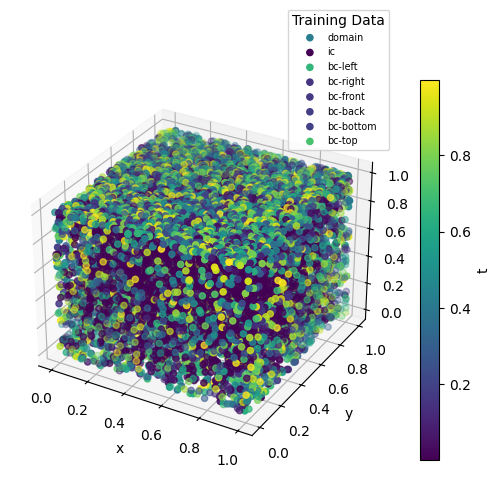

In [5]:
# Generate the training data
dg = DataGeneratorXYZT(
    X=[x_min, x_max],
    Y=[y_min, y_max],
    Z=[z_min, z_max],
    T=[t_min, t_max],
    targets=['domain', 'ic', 'bc-left', 'bc-right', 'bc-front', 'bc-back', 'bc-bottom', 'bc-top'],
    num_sample=NUM_SAMPLES,
)
dg.plot_data()

In [6]:
# 2D Terzaghi Consolidation Problem
pd_x, pd_y, pd_z, pd_t = diff(pd, xd), diff(pd, yd), diff(pd, zd), diff(pd, td)
pd_xx = diff(pd_x, xd)
pd_yy = diff(pd_y, yd)
pd_zz = diff(pd_z, zd)

# PDE Equation and BCs
PDE_3D = cx*pd_xx + cy*pd_yy + cz*pd_zz - pd_t

bc_ini = (td == t_min) * abs(pd - p0/p_star)
bc_left = (xd == x_min) * abs(pd)
bc_right = (xd == x_max) * abs(pd)
bc_front = (yd == y_min) * abs(pd)
bc_back = (yd == y_max) * abs(pd)
bc_bottom = (zd == z_min) * abs(pd_z)
bc_top = (zd == z_max) * abs(pd_z)

targets_3D = [sn.PDE(PDE_3D), bc_ini, bc_left, bc_right, bc_front, bc_back, bc_bottom, bc_top]

input_data_3D, target_data_3D = dg.get_data()

In [7]:
adaptive_weights = {'method': 'NTK', 'freq':200}
epochs = 1000
batch_size = 50

initial_lr = 1e-3
final_lr = initial_lr/100

learning_rate = {
    "scheduler": "ExponentialDecay", 
    "initial_learning_rate": initial_lr,
    "final_learning_rate": final_lr, 
    "decay_epochs": epochs
}

In [8]:
train = False
load_weights = not train

# Create and train the model
model = sn.SciModel(
    [xd, yd, zd, td],
    targets_3D,
    "mse",
    "Adam",
    load_weights_from = 'Terzaghi_3D_100k.hdf5' if load_weights else None 
)

if train:
    global H
    H = model.train(
        input_data_3D,
        target_data_3D,
        epochs=epochs,
        batch_size=batch_size,
        learning_rate=1e-3,
        stop_loss_value=1e-8,
        stop_after=None,
        verbose=2,
        adaptive_weights=adaptive_weights
    )

    model.save_weights('Terzaghi3Dtest_trained_weights.hdf5')

In [9]:
if train:
    loss = H.history["loss"]
    learning_rate = H.history["lr"]

    def cust_semilogx(AX, X, Y, xlabel, ylabel, title):
        if X is None:
            im = AX.semilogy(Y)
        else:
            im = AX.semilogy(X, Y)
        if xlabel is not None: AX.set_xlabel(xlabel)
        if ylabel is not None: AX.set_ylabel(ylabel)
        if title is not None: AX.set_title(title)

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    cust_semilogx(ax[0], None, np.array(loss) / loss[0], "epochs", "L/L0", "Loss")
    cust_semilogx(ax[1], None, np.array(learning_rate), "epochs", "lr", "Learning Rate")

    fig.subplots_adjust(left=0.1, right=0.9, bottom=0.15, top=0.9, wspace=0.3, hspace=0.2)
    plt.savefig('Epochs_3D.png',dpi=600)
    plt.show()

### PINN and Exact Solution

In [10]:
# Load exact solution data

# Needs HPC.

### Animation

In [ ]:
import time
from matplotlib.animation import FuncAnimation

N = 35 # Grid number
Nx = Ny = Nz = N
Nt = 21600

v_min, v_max = 0., 1.0 # Change for mesh-free evaluation

xs = np.linspace(v_min, v_max, N)
ys = np.linspace(v_min, v_max, N)
zs = np.linspace(v_min, v_max, N)
ts = np.linspace(t_min, t_max, Nt)

# Meshgrid for 3D evaluation
Xtest, Ytest, Ztest = np.meshgrid(xs, ys, zs, indexing='ij')

# Flatten data for 3D plotting
x_flat = Xtest.flatten()
y_flat = Ytest.flatten()
z_flat = Ztest.flatten()

# Initialize figure and axis
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': '3d'})

# Initial plot (this will be updated in each frame)
scatter = ax.scatter([], [], [], c=[], cmap='jet', marker='o', alpha=1., vmin=0, vmax=1)

# Set axis limits
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_zlim([0, 1])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set the total number of frames and interval for desired FPS
num_frames = 30  # 30 FPS * 3 seconds
fps = 30
interval = 1000 / fps  # Approx. 33.33 ms per frame for 30 FPS

# Total start time
start_time = time.time()

# Initialize variables for time tracking
previous_frame_time = start_time
smoothed_frame_time = 0.0  # Initialize for exponential smoothing

# Smoothing factor for exponential moving average (EMA), set between 0 and 1
alpha = 0.1

# Add a text label for time (you may want to use 3D coordinates to ensure visibility in a 3D plot)
time_text = ax.text2D(0.05, 0.95, '', transform=ax.transAxes, fontsize=12, color='black')

# Define update function for animation
def update(frame):
    global previous_frame_time, smoothed_frame_time
    
    # Get current time and calculate time taken for this frame
    current_time = time.time()
    frame_time = current_time - previous_frame_time
    previous_frame_time = current_time
    
    # Apply exponential smoothing to frame time
    if smoothed_frame_time == 0:
        smoothed_frame_time = frame_time  # Initialize at the first frame
    else:
        smoothed_frame_time = alpha * frame_time + (1 - alpha) * smoothed_frame_time
    
    # Estimate remaining time based on smoothed frame time
    remaining_time = smoothed_frame_time * (num_frames - frame - 1)
    
    # Print predicted time remaining
    progress_message = f"Frame {frame+1}/{num_frames}, Predicted time remaining: {remaining_time:.2f} seconds"

    with open(f"log.txt", "a") as file:
        file.write(progress_message + "\n")
    
    t_index = int(frame * (Nt-1))
    
    input_test = [Xtest.flatten(), Ytest.flatten(), Ztest.flatten(), np.full(Xtest.flatten().shape, ts[t_index])]
    
    # Evaluate model predictions at the specific time point
    p_pred_fixed_time = pd.eval(input_test).reshape(Xtest.shape)
    p_flat = p_pred_fixed_time.flatten()

    mask = (y_flat >= 0.5) & (y_flat <= 1.0)
    
    # Update scatter plot data
    scatter._offsets3d = x_flat[mask], y_flat[mask], z_flat[mask]
    scatter.set_array(p_flat[mask])
    
    # Update the time text
    current_time = ts[t_index]
    time_text.set_text(f't = {current_time:.2f}')
    
    return scatter, time_text

# Create the animation
ani = FuncAnimation(fig, update, frames=np.linspace(0, 1, num_frames), interval=num_frames, blit=False)

# Add a colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(scatter, cax=cbar_ax, label='Normalized Excess Pore Water Pressure, u/u0')

# Save or display the animation
ani.save("3D-MeshFree-Animation.gif", dpi=80)

### Mesh-Free

In [12]:
N = 60 # Grid number
Nx = Ny = Nz = N
Nt = 21600

v_min, v_max = 0.5, 0.6 # Change for mesh-free evaluation

xs = np.linspace(v_min, v_max, N)
ys = np.linspace(v_min, v_max, N)
zs = np.linspace(v_min, v_max, N)
ts = np.linspace(t_min, t_max, Nt)

# Meshgrid for 3D evaluation
Xtest, Ytest, Ztest = np.meshgrid(xs, ys, zs, indexing='ij')

# Adjustments for single axis and single plot per time point
fig, axs = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': '3d'})

for i, time_point in enumerate([0.2, 0.5, 1.0]):
    # PINN Result
    t_index = int(time_point * (Nt-1))
    input_test = [Xtest.flatten(), Ytest.flatten(), Ztest.flatten(), np.full(Xtest.flatten().shape, ts[t_index])]
    
    # Evaluate model predictions at the specific time point
    p_pred_fixed_time = pd.eval(input_test).reshape(Xtest.shape)
    
    # Flatten data for 3D plotting
    x_flat = Xtest.flatten()
    y_flat = Ytest.flatten()
    z_flat = Ztest.flatten()
    
    p_flat = p_pred_fixed_time.flatten()
    
    mask = (y_flat >= 0.5) & (y_flat <= 1.0)

    # Plotting PINN result (single axis)
    scatter = axs[i].scatter(x_flat[mask], y_flat[mask], z_flat[mask], c=p_flat, cmap='jet', marker='o', alpha=1., vmin=0, vmax=1)
    axs[i].set_title(f'PINN at t = {time_point}')
    axs[i].set_xlabel('X')
    axs[i].set_ylabel('Y')
    axs[i].set_zlabel('Z')

# Add a colorbar with a specific axis location outside the plots
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(scatter, cax=cbar_ax, label='Normalized Excess Pore Water Pressure, u/u0')

plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make space for colorbar
plt.savefig("3D-MeshFree.png", dpi=600)
plt.show()

### Exact Sol. Comparison

In [13]:
# Define the evaluation grid
N = 30 # Grid number
Nx = Ny = Nz = N
Nt = 21600
xs = np.linspace(x_min, x_max, Nx)
ys = np.linspace(y_min, y_max, Ny)
zs = np.linspace(z_min, z_max, Nz)
ts = np.linspace(t_min, t_max, Nt)

# Meshgrid for 3D evaluation
Xtest, Ytest, Ztest = np.meshgrid(xs, ys, zs, indexing='ij')

# Loop through different time points to plot 3D contours
fig, axs = plt.subplots(3, 3, figsize=(18, 12), subplot_kw={'projection': '3d'})

for i, time_point in enumerate([0.2, 0.5, 1.0]):
    # PINN Result
    t_index = int(time_point * (Nt-1))
    input_test = [Xtest.flatten(), Ytest.flatten(), Ztest.flatten(), np.full(Xtest.flatten().shape, ts[t_index])]
    
    # Evaluate model predictions at the specific time point
    p_pred_fixed_time = pd.eval(input_test).reshape(Xtest.shape)
    
    # Extract the exact pore pressure at the specified time
    u_t = u[:, :, :, t_index]
    
    # Calculate the difference/errors
    difference = p_pred_fixed_time - u_t
    
    # Flatten data for 3D plotting
    x_flat = Xtest.flatten()
    y_flat = Ytest.flatten()
    z_flat = Ztest.flatten()
    
    p_flat = p_pred_fixed_time.flatten()
    u_flat = u_t.flatten()
    d_flat = difference.flatten()

    # Filter to include only the specified y range
    mask = (Y_flat >= 0.5) & (Y_flat <= 1.0)
    
    # Plotting PINN result
    axs[i, 0].scatter(x_flat[mask], y_flat[mask], z_flat[mask], c=p_flat, cmap='jet', marker='o', alpha=1., vmin=0, vmax=1)
    axs[i, 0].set_title(f'PINN at t = {time_point}')
    axs[i, 0].set_xlabel('X')
    axs[i, 0].set_ylabel('Y')
    axs[i, 0].set_zlabel('Z')
    axs[i, 0].set_xlim([0, 1])
    axs[i, 0].set_ylim([0, 1])
    axs[i, 0].set_zlim([0, 1])

    # Plotting exact solution
    axs[i, 1].scatter(x_flat[mask], y_flat[mask], z_flat[mask], c=u_flat, cmap='jet', marker='o', alpha=1., vmin=0, vmax=1)
    axs[i, 1].set_title(f'Exact Solution at t = {time_point}')
    axs[i, 1].set_xlabel('X')
    axs[i, 1].set_ylabel('Y')
    axs[i, 1].set_zlabel('Z')
    axs[i, 0].set_xlim([0, 1])
    axs[i, 0].set_ylim([0, 1])
    axs[i, 0].set_zlim([0, 1])
    
    # Plotting difference/errors
    axs[i, 2].scatter(x_flat[mask], y_flat[mask], z_flat[mask], c=d_flat, cmap='jet', marker='o', alpha=1., vmin=-1, vmax=1)
    axs[i, 2].set_title(f'Difference at t = {time_point}')
    axs[i, 2].set_xlabel('X')
    axs[i, 2].set_ylabel('Y')
    axs[i, 2].set_zlabel('Z')
    axs[i, 0].set_xlim([0, 1])
    axs[i, 0].set_ylim([0, 1])
    axs[i, 0].set_zlim([0, 1])

fig.colorbar(axs[0, 0].collections[0], ax=axs[:, 0], label='Normalized Excess Pore Water Pressure, u/u0')
fig.colorbar(axs[0, 1].collections[0], ax=axs[:, 1], label='Normalized Excess Pore Water Pressure, u/u0')
fig.colorbar(axs[0, 2].collections[0], ax=axs[:, 2], label='Difference/Error')

plt.tight_layout()
plt.savefig("3D-Contour-Plots.png", dpi=600)
plt.show()